# PHYS 3317 -- Hartree

Upload completed notebook to Blackboard at end of recitation section (or before next recitation if you do not complete it during the recitation period)

<font color="red"><em> Vineet Kamat </em></font>

In class we have been modelling multi-electron atoms using the Hartree approximation.  This is a some-what intuitive model, where one accounts for electron-electron interactions via a self-consistent potential.  That is to model the ground state of an $N$-electron system, one fills the lowest $N$ eigenstates of the following Schrodinger equation

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

\begin{equation}
\left[-\frac{\nabla^2}{2m} + V_{\rm eff}(r)\right] \phi_n(r)=\epsilon_n \phi_n(r)
\end{equation}

The effective potential should be chosen so that

$$
V_{\rm eff}(r) = V_{\rm ext}(r) + \int dr^\prime\, V_{ee}(r-r^\prime) \rho(r^\prime)
$$

Where $V_{\rm ext}(r)$ is the external potential (say the Coulomb potential from the nucleus), $V_{ee}(r)$ is the potential energy of two electrons separated by distance $r$ (again, a Coulomb potential), and the electron distribution is

$$
\rho(r) =\sum_{n=1}^N |\phi_n(r)|^2.
$$

Because $V_{\rm eff}$ depends on the solution of the Schrodinger equation, we call it a "self-consistent potential."

A typical way to solve these equations is through iteration.  One first makes a "guess" for $\rho$.  For example, $\rho=0$.  One then calculates the states $\phi_n$.  One uses these $\phi_n$ to calculate $\rho$.  This gives a $V_{\rm eff}$ which can be used to calculate better $\phi_n$'s.  These $\phi_n$'s give a better approximation to $\rho$... and so on  

## Fermi Gas in a Harmonic Trap

Here we will use this iterative Hartree approach to calculate the density profile of a gas of fermionic Lithium atoms in a 1D harmonic oscillator potential.

That is, we imagine that we have a 1D harmonic trap, that we put $N$ atoms in.  We will use dimensionless units where $\hbar=m=1$, and  take the external potential to be

$$
V_{\rm ext} = x^2/2
$$

The interaction between neutral atoms is short-range, so the atom-atom interactions can be well-approximated as

$$
V_{aa}=g \delta(x)
$$

where $g$ is a constant which parameterizes the interaction strength.

Thus we need to solve

\begin{equation}
\left[-\frac{\partial_x^2}{2} + V_{\rm eff}(x)\right] \phi_n(x)=\epsilon_n \phi_n(x)
\end{equation}

where

\begin{eqnarray}
V_{\rm eff}(x) &=& V_{\rm ext}(x) + \int dx^\prime\, V_{a}(x-x^\prime) \rho(x^\prime)\\
&=& x^2/2 + g \rho(x)
\end{eqnarray}

with

$$
\rho(x)=\sum_{n=1}^N |\phi_n(x)|^2
$$

Refer to previous activities to complete the following program

In [3]:
# Load in the necessary packages

%pylab inline

from __future__ import division  #get rid of integer division bug
from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

Populating the interactive namespace from numpy and matplotlib


/Users/vineetkamat/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hstack', 'vstack', 'eye', 'kron', 'rand', 'extract', 'random', 'find', 'tril', 'identity', 'triu', 'bmat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
# complete the missing lines
# the easiest thing to do is to copy and paste from an earlier lab
#
#  This should be fast to do -- don't waste a lot of time thinking about it
#
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    

Run the following to test SecondDerivMatrix.  

In [5]:
testder=SecondDerivMatrix(numpoints=20,dx=0.1,periodic=True)

In [6]:
showmat(testder.todense())

-200,100,,,,,,,,,,,,,,,,,,100
100,-200,100,,,,,,,,,,,,,,,,,
,100,-200,100,,,,,,,,,,,,,,,,
,,100,-200,100,,,,,,,,,,,,,,,
,,,100,-200,100,,,,,,,,,,,,,,
,,,,100,-200,100,,,,,,,,,,,,,
,,,,,100,-200,100,,,,,,,,,,,,
,,,,,,100,-200,100,,,,,,,,,,,
,,,,,,,100,-200,100,,,,,,,,,,
,,,,,,,,100,-200,100,,,,,,,,,
,,,,,,,,,100,-200,100,,,,,,,,


In [9]:
# complete the missing lines
# the easiest thing to do is to copy and paste from an earlier lab
#
# Life will be easier later on if you use the version that we made for the time evolution
# where you specify the potential by simply a list of numbers.
#
def PotentialMatrix(potential):
    """PotentialMatrix(potential)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potential -- the list of the potential values
    """
    
    ln=len(potential)
    return dia_matrix((potential,0),shape=(ln,ln))


Run the following to test PotentialMatrix.  

In [10]:
grid=arange(-1,1,0.1)
harmpot=grid**2/2
potmat=PotentialMatrix(harmpot)
showmat(potmat.todense())

0.5,,,,,,,,,,,,,,,,,,,
,0.41,,,,,,,,,,,,,,,,,,
,,0.32,,,,,,,,,,,,,,,,,
,,,0.25,,,,,,,,,,,,,,,,
,,,,0.18,,,,,,,,,,,,,,,
,,,,,0.13,,,,,,,,,,,,,,
,,,,,,0.08,,,,,,,,,,,,,
,,,,,,,0.05,,,,,,,,,,,,
,,,,,,,,0.02,,,,,,,,,,,
,,,,,,,,,$0.5\cdot10^{-2}$,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [11]:
# complete the missing lines
# the easiest thing to do is to copy and paste from an earlier lab

def HamiltonianMatrix(potential,dx,periodic=True,hbar=1,mass=1):
    """HamiltonianMatrix(potential,dx,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potential -- a list of values for the potential
    dx -- the grid spacing
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    numpoints=len(potential)
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potential) #calculate potential energy operator
    return kin+pot

Run the following to test HamiltonianMatrix.  

In [12]:
grid=arange(-5,5,0.1)
delta=0.1
harmpot=grid**2/2
hammat=HamiltonianMatrix(harmpot,delta)

In [13]:
eigsh(hammat, # matrix to diagonalize
 k=10, # find 10 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([0.4996873 , 1.49843574, 2.49593054, 3.49217088, 4.48713663,
       5.48096736, 6.47267185, 7.46730226, 8.44115835, 9.47719576])

In [14]:
# Make a function which is called with a Hamiltonian matrix, and returns the 
# n eigenvectors with eigenvalues closest to zero

def lowesteigenvectors(mat,n):
    """ lowesteigenvectors(mat,n) Returns an array of the k eigenvectors of mat
        whose eigenvalues are closest to zero"""
    en,vecs= eigsh(mat,k=n, sigma=0,  return_eigenvectors=True)
    return vecs

Test with the following

In [15]:
vecs=lowesteigenvectors(hammat,5)

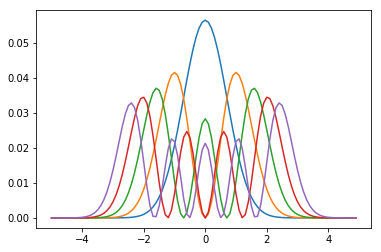

In [16]:
for vec in transpose(vecs):
    plot(grid,abs(vec)**2)

We next need a function which will take an array of eigenvectors, and will normalize them.  That is, if $\delta$ is the spacing between lattice sites, we want them normalized so that in the end

$$
\int  |\phi(x)|^2 dx\approx\sum_j |\phi(x_j)|^2 \delta =1
$$

Here is a straightforward way to do this

In [17]:
# First we calculate what happens if we sum phi^2
# vecs is a list of 5 eigenvectors, the following code calculates the sum of phi^2

oldnorms=(abs(vecs)**2).sum(0)
oldnorms

array([1., 1., 1., 1., 1.])

In [18]:
# next we divide the eigenvectors by the square root of these norms times delta
# The following code does that in one fell swoop

newvecs=vecs/(sqrt(oldnorms*delta))

In [19]:
# we can check to see if it works
# we should get five 1's when we run this line

delta*(abs(newvecs)**2).sum(0)

array([1., 1., 1., 1., 1.])

In [22]:
# Encapsulate this algorithm into a function
def normvecs(vecs,delta):
    """ normvecs(vecs,delta) takes an array of eigenvectors, vecs, and normalizes them, assuming
    the spatial grid is spaced by delta """
    oldnorms=(abs(vecs)**2).sum(0)
    oldnorms
    newvecs=vecs/(sqrt(oldnorms*delta))
    return newvecs

Test it with the following cell.  This is a list of 3 non-normalized wavefunctions, each of which when normalized should become (1/sqrt(2),1/sqrt(2)) when normalized.

In [23]:
normvecs(array([[2,3,4],[2,3,4]]),1)

array([[0.70710678, 0.70710678, 0.70710678],
       [0.70710678, 0.70710678, 0.70710678]])

Next we want to calculate rho.  We can again use the "sum" method to do this.  The following code generates a bunch of eigenvectors, then sums them, plotting the individual eigenvectors and their sums

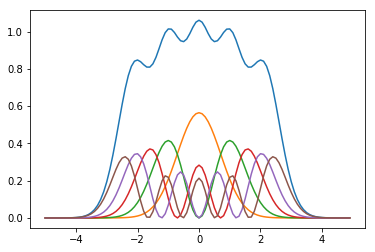

In [24]:
grid=arange(-5,5,0.1)
delta=0.1
harmpot=grid**2/2
hammat=HamiltonianMatrix(harmpot,delta)
vecs=lowesteigenvectors(hammat,5)
nvecs=normvecs(vecs,delta)

psisq=abs(nvecs)**2
dens=psisq.sum(1)

plot(grid,dens)

for vec in transpose(nvecs):
    plot(grid,abs(vec)**2)
    


In [25]:
# Make a function which takes the normalized vectors as its argument, then spits out the density

def finddens(vecs):
    """ finddens(vecs) takes an array of normalized eigenvectors, and returns their density """
    psisq=abs(vecs)**2
    dens=psisq.sum(1)
    return dens

Test it with the following code.  Which takes 20 particles in a square box.  The density should be mostly flat, with some wiggles near the edge.  These wiggles are known as "Friedel Oscillations" and can be important in solid state systems.  If everything works, the area under the density curve should be exactly 20.

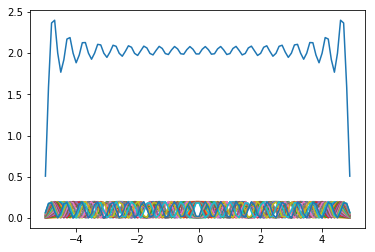

In [28]:
grid=arange(-5,5,0.1)
delta=0.1
flatpot=zeros(len(grid))
hammat2=HamiltonianMatrix(flatpot,delta,periodic=False)
vecs2=lowesteigenvectors(hammat2,20)
nvecs2=normvecs(vecs2,delta)
dens2=finddens(nvecs2)

plot(grid,dens2)

for vec in transpose(nvecs2):
    plot(grid,abs(vec)**2)

Now we want to make a function which when called with a density, solves the Schrodinger equation, and spits out a new density.

\begin{eqnarray}
V_{\rm eff}(x) &=& x^2/2 + g \rho(x)
\end{eqnarray}

In [35]:
# Complete the following code
def HartreeIterate(olddens,numatoms,g,grid):
    """ HartreeIterate(olddens,num,g) takes a trial density, olddens, generates
    the Hartree potential, solves the Schrodinger equation, then returns the new density.
    It calls all of the functions we previously defined:  finddens, normvecs,
    HamiltonianMatrix"""
    
    rho = g*olddens
    x_sqr = ((grid**2)/2)
    pot = x_sqr + rho
    Ham = HamiltonianMatrix(pot, .1, periodic = False)
             
    vecs = lowesteigenvectors(Ham, numatoms)
    delta = grid[1]-grid[0]
    nvecs = normvecs(vecs,delta)
    newdens = finddens(nvecs)
             
    return newdens
    

Test with the following.  This shows two Hartree iterations, starting with a "guess" of zero

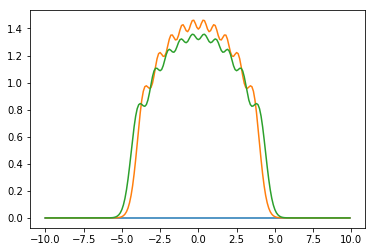

In [36]:
grid=arange(-10,10,0.1)
startdens=zeros(len(grid))
plot(grid,startdens)

dens1=HartreeIterate(startdens,10,2,grid)
plot(grid,dens1)

dens2=HartreeIterate(dens1,10,2,grid)
plot(grid,dens2)

Make a loop which goes through 50 iterations,with 10 particles, and g=2 -- plotting the density at each step.  You should find that the algorithm converges, and the density profile is wider than the profile you find for non-interacting particles (which is just the profile from the 1st iteration).

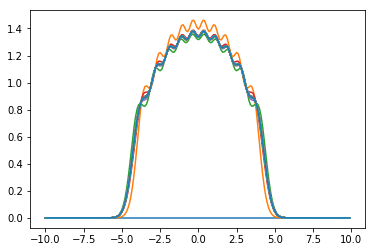

In [39]:
grid=arange(-10,10,0.1)
startdens=zeros(len(grid))
plot(grid,startdens)

for x in range(0,50,1):
    dens1=HartreeIterate(startdens,10,2,grid)
    plot(grid,dens1)
    startdens = dens1

For stronger interactions, the naive iteration algorithm is unstable, but here is a slight variation which works.  The trick is that we mix the new solution with the old one.

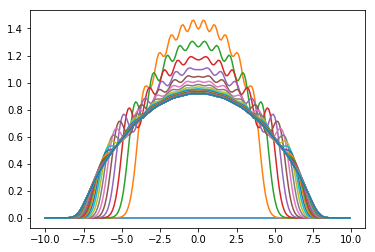

In [40]:
grid=arange(-10,10,0.1)
startdens=zeros(len(grid))
plot(grid,startdens)
n=0

dens=startdens
while n<50:
    newdens=HartreeIterate(dens,10,30,grid)
    plot(grid,newdens)
    dens=(0.9*dens+0.1*newdens)
    n=n+1

Write a function which will automate this calculation -- taking the parameters, and spitting out the density profile

In [41]:
# Complete this function
def solveHartree(grid,numparticles,g,numiterations):
    """ solveHartree(grid,numparticles,g,numiterations) iterates the Hartree equations
    for numparticles fermions trapped in a 1D harmonic oscillator potential, with
    a point interaction of strength g.  It iterates the equations
    numiterations times starting with a density of zero. """
    grid=arange(-10,10,0.1)
    startdens=zeros(len(grid))
    n=0

    dens=startdens
    while n<50:
        newdens=HartreeIterate(dens,10,30,grid)
        dens=(0.9*dens+0.1*newdens)
        n=n+1
    
    return dens
    


Test with the following line

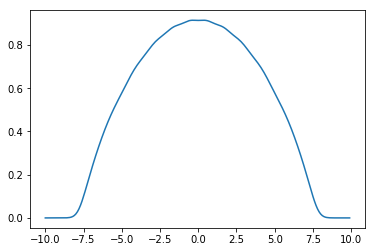

In [42]:
d30=solveHartree(grid=arange(-10,10,0.1),numparticles=10,g=30,numiterations=50)
plot(arange(-10,10,0.1),d30)

Write a function which takes a density profile and a grid, returning the rms size of the cloud

$$
\sigma=\sqrt{\frac{\int \rho(x) x^2 dx}{\int \rho(x)  dx}}
$$

In [47]:
def width(density,grid):
    """width calculates the rms width of a density profile on a grid """
    rhointegral = 0
    for x in arange(len(grid)):
        rhointegral = rhointegral + density[x]
    
    rhoxintegral = 0
    for x in arange(len(grid)):
        rhoxintegral = rhoxintegral + density[x]*grid[x]**2
        
    sig = (rhoxintegral/rhointegral)**(1/2)
    
    return sig

Test with the following line

In [48]:
width(d30,arange(-10,10,0.1))

3.6078252029923927

For the case of 10 particles, find the width $\sigma$ for g=0,5,10,15,20.  Plot $\sigma$ vs $g$.  Label your graph.

In [49]:
darray=[]
warray = []
x = grid=arange(-10,10,0.1)
garr = [0,5,10,15,20]
for g in garr:
    d = solveHartree(x,numparticles=10,g=5,numiterations=50)
    darray = darray + [d]
    warray = warray + [width(d,x)]

print(warray)

[3.607825202992397, 3.6078252029923945, 3.607825202992391, 3.6078252029923936, 3.6078252029923923]


In [51]:
print(garr)

[0, 5, 10, 15, 20]


Text(0.5,1,'g value vs width')

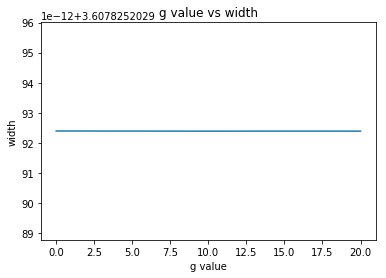

In [55]:
plot(garr,warray)
xlabel("g value")
ylabel("width")
title("g value vs width")